In [5]:
import sys
sys.path.append('../../')

In [6]:
from codes.docs.analysis import data_preprocessing, logging_outputs

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# 1. Data Preprocessing and Importing

In [8]:
full_dataset=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='allSubjectsWithKANA_AALVolumes').drop('ID',axis=1)
full_dataset=full_dataset.rename({'Subject':'ID'},axis=1)

In [9]:
Imperial_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='IMPERIAL ROIs LEGEND',header=None).drop([0,1],axis=1)
AAL_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='AAL LEGEND',header=None).drop(0,axis=1)

In [10]:
from string import digits
AAL_label=np.asarray([str.split(i,' ')[1] for i in np.asarray(AAL_label).reshape(-1)])
Imperial_label=np.asarray([str.strip(i.translate({ord(c): None for c in digits})) for i in (np.asarray(Imperial_label)).reshape(-1)])

In [7]:
#Reading necessary tables
schizophrenia_high_scores_european=data_preprocessing.read_table_from_txt('./dataset/SCZ2_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',add_EP=False)
ancestral_PCA_european=data_preprocessing.read_table_from_txt('./dataset/file3_only_europ_10pcs_pca.eigenvec',add_EP=False)

In [8]:
#Merge the tables together using the european ID as the key.
from functools import reduce
european_ID_dataset=reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'),[full_dataset,schizophrenia_high_scores_european,ancestral_PCA_european])
#retain the last session in cases of duplication
european_ID_dataset=european_ID_dataset.drop_duplicates(subset='ID',keep='last')
european_ID_dataset=european_ID_dataset.reset_index(drop=True)


## 1.2 Removing outliers

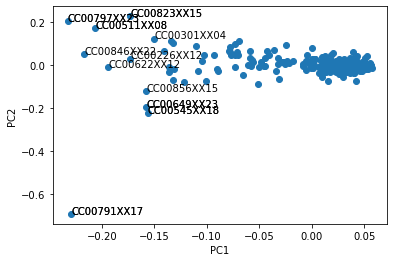

In [9]:
from scipy import stats
zscores=np.abs(stats.zscore(european_ID_dataset.loc[:,('PC1','PC2')].astype('float64'),axis=0))
outliers=np.where(zscores>=2.5)[0]#remove anything more than 3 st. deviation from the mean.

#removing outliers using the ancestrial PCA
fig,ax=plt.subplots()
ax.scatter(european_ID_dataset.loc[:,'PC1'],european_ID_dataset.loc[:,'PC2'])
for i,txt in enumerate(european_ID_dataset.loc[outliers,'ID']):
    ax.annotate(txt,(european_ID_dataset.loc[outliers[i],'PC1'],european_ID_dataset.loc[outliers[i],'PC2']))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

european_ID_dataset_without_outliers=european_ID_dataset.drop(outliers).reset_index(drop=True)

In [10]:
european_volumetric_AAL_matrix=np.asarray(european_ID_dataset_without_outliers.iloc[:,21:114])
european_volumetric_Imperial_matrix=np.asarray(european_ID_dataset_without_outliers.iloc[:,114:201])
european_ancestral_PCA=np.asarray(european_ID_dataset_without_outliers.iloc[:,212:222])
european_PRS_schizophrenia=np.asarray(european_ID_dataset_without_outliers.iloc[:,201:212])

In [11]:
#extracting ages, total volume, gender
european_age_at_scan=np.asarray(european_ID_dataset_without_outliers.iloc[:,3])
european_gestational_age=np.asarray(european_ID_dataset_without_outliers.iloc[:,2])
european_total_volume=np.asarray(european_ID_dataset_without_outliers.iloc[:,5])
european_icv=np.asarray(european_ID_dataset_without_outliers.iloc[:,4])

## 1.3 Adjusting for covariates

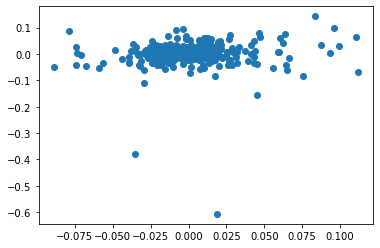

In [12]:
plt.scatter(european_ancestral_PCA[:,1],european_ancestral_PCA[:,2])
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

In [13]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_PRS_schizophrenia,european_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_PRS_schizophrenia=adjusted_european_PRS_schizophrenia.astype('float64')

adjusted_european_volumetric_AAL_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_AAL_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_AAL_matrix=adjusted_european_volumetric_AAL_matrix.astype('float64')

adjusted_european_volumetric_Imperial_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_Imperial_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_Imperial_matrix=adjusted_european_volumetric_Imperial_matrix.astype('float64')

#remove the CSF, Extracranial and Intracranial volume from adjusted_european_volumetric_Imperial_matrix
adjusted_european_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[82,83,84],axis=1)
Imperial_label=np.delete(Imperial_label,[82,83,84],axis=0)

#remove the WM from adjusted_european_structural_schizophrenia
adjusted_european_GM_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=1)
Imperial_GM_labels=np.delete(Imperial_label,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=0)

In [11]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [16]:
save_to_npy('./preprocessed_data/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label)

In [12]:
save_to_npy('./preprocessed_data/',AAL_label)

In [13]:
! ls preprocessed_data

AAL_label.npy
Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
graph_metrics_vol_high_risk.txt
graph_metrics_vol_low_risk.txt
high_low_risk_vol_dataset.npy
